In [1]:
# Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest, proportions_chisquare
from scipy.stats import shapiro, mannwhitneyu, t, norm
from statsmodels.stats import proportion

Компания заинтересована в ответах на вопросы:
1) Будет ли кампания успешной?
2) Если кампания была успешной, насколько этот успех можно объяснить рекламой?  
Чтобы ответить на второй вопрос, провели A/B тестирование.

Большинство людей видели рекламу (экспериментальная группа B). А небольшая часть людей (контрольная группа A) вместо этого увидели объявление государственной службы (PSA) (или ничего) точно такого же размера и в том же месте, где обычно находится реклама.

***Бизнес-вопрос*** «Насколько успех рекламной кампании обоснован именно рекламой?»  

**Словарь данных:**  
**user id**: Идентификатор пользователя (уникальный).  
**test group**: Если "ad", то человек видел рекламу, если "psa", то он видел только объявление государственной службы.  
**converted**: Если человек купил продукт, то True, иначе False.  
**total ads**: Количество рекламы, увиденной человеком.  
**most ads day**: День, в который человек увидел наибольшее количество рекламы.  
**most ads hour**: Час дня, в который человек увидел наибольшее количество рекламы.  

### Анализ структуры данных и предобработка

In [2]:
# Чтение файла и запись в датафрейм
ab_data = pd.read_csv('AB-tests_HW/marketing_AB.csv')
ab_data

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14
...,...,...,...,...,...,...,...
588096,588096,1278437,ad,False,1,Tuesday,23
588097,588097,1327975,ad,False,1,Tuesday,23
588098,588098,1038442,ad,False,3,Tuesday,23
588099,588099,1496395,ad,False,1,Tuesday,23


In [3]:
# Удаление ненужного столбца с дублирующей информацией о номере строки
ab_data.drop('Unnamed: 0', axis=1, inplace=True)
ab_data

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14
...,...,...,...,...,...,...
588096,1278437,ad,False,1,Tuesday,23
588097,1327975,ad,False,1,Tuesday,23
588098,1038442,ad,False,3,Tuesday,23
588099,1496395,ad,False,1,Tuesday,23


In [4]:
# Кол-во пользователей, id уникальные
# Пользователи уникальные и нет их задвоения (кол-во строк совпадает с кол-вом уникальных пользователей)
ab_data['user id'].nunique()

588101

In [5]:
# Информация о датафрейме, кол-во строк - 588101, кол-во колонок - 6, нет пропущенных значений, 
# приведены типы данных по колонкам
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 23.0+ MB


In [6]:
# Выведение уникальных значений колонок с подсчетом кол-ва этих значений.
# По колонке 'test group' заметно несбалансированное кол-во тестируемых пользователей.
# Также нет "скрытых" пропущенных значений в колонках.
# Пятница - день с большим кол-вом пользователей, в котором пользователям показывали наибольшее кол-во рекламы, 
# но по дням недели примерно равномерно распределены показы наибольшего кол-ва рекламы
# В дневные часы большее кол-во пользователей, в которых пользователям показывали наибольшее кол-во рекламы,
# далее идут вечерние часы, и меньше всего в утренние часы.
for col in ab_data.columns:
    print(ab_data[col].value_counts())

1069124    1
1116707    1
1275145    1
1338348    1
1352590    1
          ..
1381349    1
1526572    1
1144916    1
1321771    1
1237779    1
Name: user id, Length: 588101, dtype: int64
ad     564577
psa     23524
Name: test group, dtype: int64
False    573258
True      14843
Name: converted, dtype: int64
1       56606
2       39827
5       29303
3       28661
4       23426
        ...  
1302        1
1035        1
716         1
1014        1
729         1
Name: total ads, Length: 807, dtype: int64
Friday       92608
Monday       87073
Sunday       85391
Thursday     82982
Saturday     81660
Wednesday    80908
Tuesday      77479
Name: most ads day, dtype: int64
13    47655
12    47298
11    46210
14    45648
15    44683
10    38939
16    37567
17    34988
18    32323
9     31004
19    30352
21    29976
20    28923
22    26432
23    20166
8     17627
7      6405
0      5536
2      5333
1      4802
3      2679
6      2068
5       765
4       722
Name: most ads hour, dtype: int64


In [7]:
# Преобразование колонки 'converted' из bool в int
ab_data['converted'] = ab_data['converted'].astype('int8')
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  int8  
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: int64(3), int8(1), object(2)
memory usage: 23.0+ MB


In [8]:
# Если отфильтровать пользователей из группы psa и выбрать купил он продукт или нет = 0, то будет 23104 чел., 
# но это кол-во не совпадает с кол-вом пользователей в группе psa - 23524 чел.
# 420 пользователей, у которых группа psa и покупка = 1, предположим, что являются органическим трафиком, удалять их не будем.
ab_data[(ab_data['test group'] == 'psa') & (ab_data['converted'] == 0)]

,user id,test group,converted,total ads,most ads day,most ads hour
18,900681,psa,0,248,Saturday,19
38,905704,psa,0,27,Thursday,8
68,904595,psa,0,13,Tuesday,19
140,901904,psa,0,32,Wednesday,19
157,902234,psa,0,105,Tuesday,19
...,...,...,...,...,...,...
588052,900959,psa,0,16,Tuesday,22
588063,902828,psa,0,3,Tuesday,22
588066,914578,psa,0,1,Tuesday,22
588069,909042,psa,0,6,Tuesday,22


In [9]:
# Заменяем группу ad на B, группу psa на A (для удобства и однозначной интерпретации)
ab_data['test group'] = ab_data['test group'].replace({'ad': 'B', 'psa': 'A'})
ab_data['test group'].value_counts()

B    564577
A     23524
Name: test group, dtype: int64

### Первичный анализ результатов A/B-тестирования

In [10]:
# Вспомогательные показатели для контрольной и тестовой групп:
# Количество посещений сайта-уникальных посетителей users_count, суммарное количество совершённых покупок converted
ab_data_group = ab_data.groupby('test group').agg({
    'user id':'count',
    'converted':'sum',
    'total ads': 'sum'
}).reset_index().rename(columns={'user id': 'users_count'})
ab_data_group

,test group,users_count,converted,total ads
0,A,23524,420,582481
1,B,564577,14423,14014701


In [11]:
# Кол-во пользователей-посещений группы B
count_b = ab_data_group[ab_data_group['test group'] == 'B']['users_count'][1]
count_b

564577

In [12]:
# Кол-во пользователей-посещений группы А
count_a = ab_data_group[ab_data_group['test group'] == 'A']['users_count'][0]
count_a

23524

In [13]:
# Датафрейм с группировкой по дням недели и группам
group_day = ab_data.groupby(['test group', 'most ads day']).agg({'user id':'count'}).\
reset_index().rename(columns={'user id': 'users_count'})

In [14]:
# Вычисление долей пользователей-посещений в группах по дням недели
group_day['perc_user'] = group_day.apply(lambda x: round((x['users_count']/count_b)*100, 2) \
if x['test group'] == 'B' else round((x['users_count']/count_a)*100, 2), axis=1)
group_day

,test group,most ads day,users_count,perc_user
0,A,Friday,3803,16.17
1,A,Monday,3502,14.89
2,A,Saturday,2858,12.15
3,A,Sunday,3059,13.00
4,A,Thursday,3905,16.60
5,A,Tuesday,2907,12.36
6,A,Wednesday,3490,14.84
7,B,Friday,88805,15.73
8,B,Monday,83571,14.80
9,B,Saturday,78802,13.96


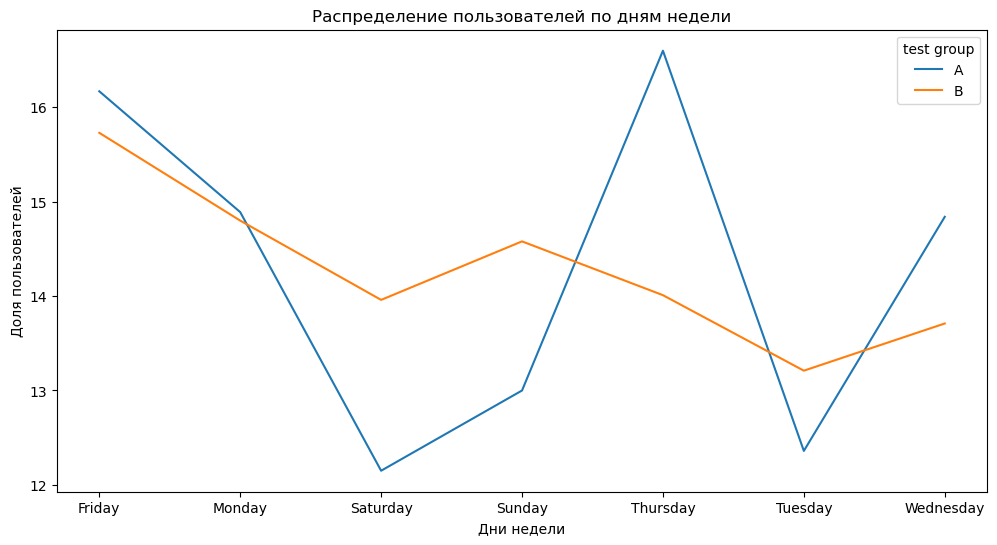

In [15]:
# Создание графика
plt.figure(figsize=(12, 6))

# Отображение данных для каждой группы
sns.lineplot(x='most ads day', y='perc_user', hue='test group', data=group_day)

# Настройка графика
plt.xlabel('Дни недели')
plt.ylabel('Доля пользователей')
plt.title('Распределение пользователей по дням недели')

# Отображение графика
plt.show()

In [16]:
# Датафрейм с группировкой по часа дня и группам
group_hour = ab_data.groupby(['test group', 'most ads hour']).agg({'user id':'count'}).\
reset_index().rename(columns={'user id': 'users_count'})

In [17]:
# Вычисление долей пользователей-посещений в группах по часам дня
group_hour['perc_user'] = group_hour.apply(lambda x: round((x['users_count']/count_b)*100, 2) \
if x['test group'] == 'B' else round((x['users_count']/count_a)*100, 2), axis=1)
group_hour

,test group,most ads hour,users_count,perc_user
0,A,0,227,0.96
1,A,1,187,0.79
2,A,2,181,0.77
3,A,3,89,0.38
4,A,4,28,0.12
5,A,5,23,0.10
6,A,6,83,0.35
7,A,7,237,1.01
8,A,8,659,2.80
9,A,9,1202,5.11


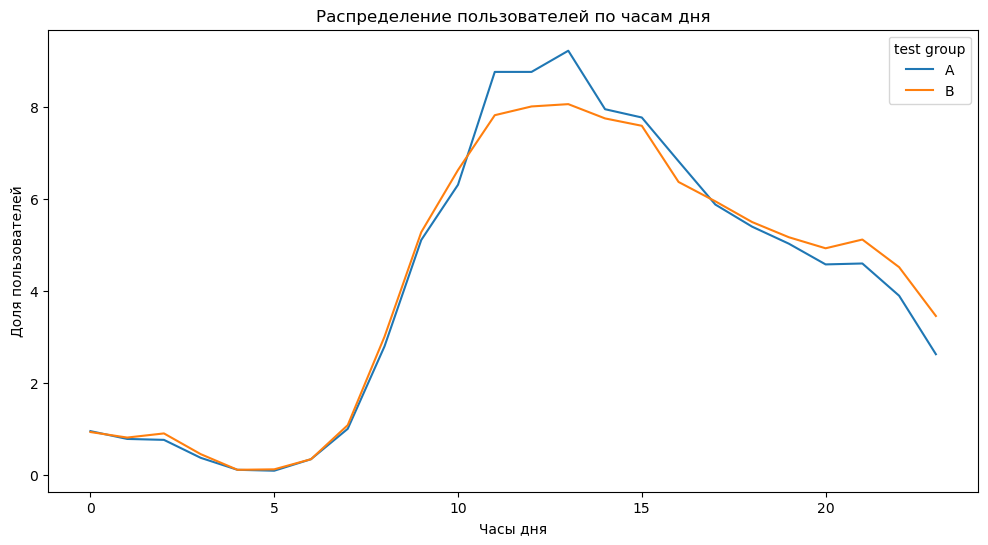

In [18]:
# Создание графика
plt.figure(figsize=(12, 6))

# Отображение данных для каждой группы
sns.lineplot(x='most ads hour', y='perc_user', hue='test group', data=group_hour)

# Настройка графика
plt.xlabel('Часы дня')
plt.ylabel('Доля пользователей')
plt.title('Распределение пользователей по часам дня')

# Отображение графика
plt.show()

После группировки на тестовую и контрольную группы видно, что кол-во посещений обоих вариантов посадочной страницы не сопоставимо, выборки не сбалансированы по кол-ву. Стоит отметить, что в двух группах сопоставимые доли по часам дня (между 10.00 и 15.00 доля чуть выше в контрольной группе), в которых человек увидел наибольшее количество рекламы. По дням недели: в субботу, воскресенье и во вторник чуть ниже доля у контрольной группы, в четверг и среду чуть выше в контрольной группе.

In [19]:
# Расчет ключевых показателей: конверсия и среднее количество рекламы, увиденной пользователем.
ab_data_group['conversion'] = ab_data_group['converted']/ab_data_group['users_count']*100
ab_data_group['avg_ads'] = ab_data_group['total ads']/ab_data_group['users_count']
ab_data_group

,test group,users_count,converted,total ads,conversion,avg_ads
0,A,23524,420,582481,1.785411,24.761138
1,B,564577,14423,14014701,2.554656,24.823365


Среднее кол-во увиденной рекламы для двух групп близко (примерно 24,8 на чел.). Различие в среднем количестве увиденной рекламы между группами A (24.76) и B (24.8) является незначительным. Вариант с показом рекламы (ad) с конверсией 2.55%, на первый взгляд, эффективнее по показателю конверсии, чем контрольный вариант (psa) с конверсией 1.79%. Это может указывать на то, что реклама в группе B более эффективна в привлечении пользователей к покупке продукта, но нужно провести статический анализ тестирования для подтверждения.

### Статистический анализ результатов A/B-тестирования

Нужно выяснить, была ли реклама успешной и является ли разница между группами статистически значимой.  
Существует ли статистическая значимость в эффективности (разнице конверсий) контрольного и тестового вариантов?

**Для конверсий**  
Нулевая гипотеза: нет различий между конверсиями контрольной (А) и тестовой (В) группами.  
p<sub>a</sub> - p<sub>b</sub> = 0  
Альтернативная гипотеза: есть различия между конверсиями групп.  
p<sub>a</sub> - p<sub>b</sub> $\neq$ 0  
$\alpha$ = 0.05  

Для проверки гипотезы равенства (при альтернативной гипотезе о различиях) пропорций мы можем воспользоваться следующим рядом статистических тестов: Z-тест для пропорций (Z-критерий), $\chi^2$ - тест

In [20]:
# Уровень значимости
alpha = 0.05

In [21]:
# Вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=ab_data_group['converted'], #число «успехов»
    nobs=ab_data_group['users_count'], #общее число наблюдений
    alternative='two-sided',
)
print('p-value: ', round(p_value, 3))
# Сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.0
Отвергаем нулевую гипотезу в пользу альтернативной


Хотим уточнить исследование и проверить гипотезу о том, что варианты А и B не просто различны между собой, а вариант В лучше варианта А по метрике конверсии.  
Нулевая гипотеза: конверсия в группе А больше либо равна конверсии в группе B.  
p<sub>a</sub> $\geq$ p<sub>b</sub>    
Альтернативная гипотеза: конверсия в группе В больше, чем конверсия в группе А.  
p<sub>a</sub> < p<sub>b</sub>    

In [22]:
# Вычисляем значение p-value для Z-теста для пропорций
_, p_value = proportions_ztest(
    count=ab_data_group['converted'], # число «успехов»
    nobs=ab_data_group['users_count'], # общее число наблюдений
    alternative='smaller' # левосторонняя альтернативная гипотеза, smaller
)
# Выводим результат на экран
print('p-value: ', round(p_value, 3))
# Сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.0
Отвергаем нулевую гипотезу в пользу альтернативной


Вариант В лучше, чем вариант А по метрике конверсия.

In [24]:
# Вычисляем значение p-value для хи-квадрат-теста для пропорций
_, p_value, c = proportions_chisquare(
    count=ab_data_group['converted'], #число «успехов»
    nobs=ab_data_group['users_count'] #общее число наблюдений
)
# Выводим результат на экран
print('p-value: ', round(p_value, 3))
# Сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.0
Отвергаем нулевую гипотезу в пользу альтернативной


Используя хи-квадрат (двухсторонний) получили аналогичный результат.    
Рекламная кампания группы B (ad) оказалась более эффективной по сравнению с группой A (psa), если судить по конверсии. Это означает, что пользователи, видевшие рекламу, чаще совершали покупки, чем те, кто видел государственные объявления. Для бизнеса это указывает на большую эффективность рекламы для стимулировании продаж.

**Для среднего**  
Нулевая гипотеза: распределение, лежащее в основе среднего кол-ва рекламы в группе А, идентично распределению, лежащему в основе среднего кол-ва рекламы в группе B  
F<sub>a</sub>(u) = F<sub>b</sub>(u)  
Альтернативная гипотеза: распределение, лежащее в основе среднего кол-ва рекламы в группе А, отлично от распределения, лежащему в основе среднего кол-ва рекламы в группе B  
F<sub>a</sub>(u) $\neq$ F<sub>b</sub>(u)  

In [25]:
# Датафрейм для группы А с кол-вом увиденной рекламы
ads_a = ab_data[(ab_data['test group'] == 'A')]['total ads']

In [26]:
# Описательная статистика для датафрейма для группы А
ads_a.describe()

count    23524.000000
mean        24.761138
std         42.860720
min          1.000000
25%          4.000000
50%         12.000000
75%         26.000000
max        907.000000
Name: total ads, dtype: float64

In [27]:
# Датафрейм для группы B с кол-вом увиденной рекламы
ads_b = ab_data[(ab_data['test group'] == 'B')]['total ads']

In [28]:
# Описательная статистика для датафрейма для группы B
ads_b.describe()

count    564577.000000
mean         24.823365
std          43.750456
min           1.000000
25%           4.000000
50%          13.000000
75%          27.000000
max        2065.000000
Name: total ads, dtype: float64

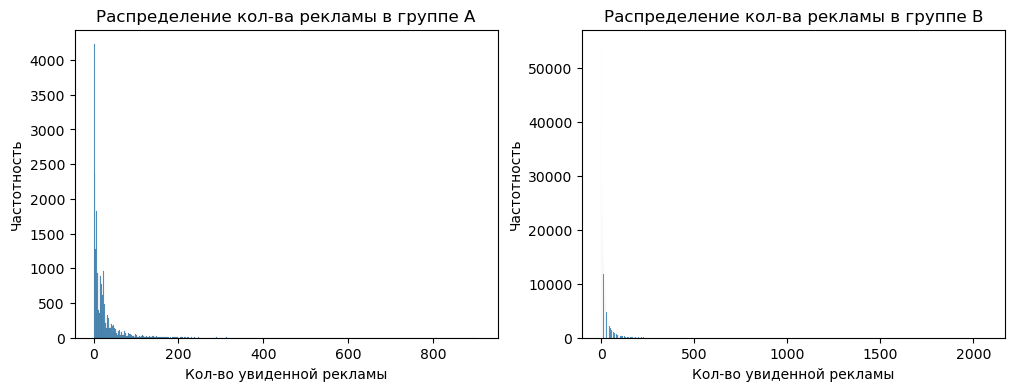

In [29]:
# Cоздаём два графика размером 12x4
fig = plt.figure(figsize=(12, 4))

# Cтроим гистограммы для кол-ва рекламы, показанной пользователям на сайте, в каждой группе
plt.subplot(121)
sns.histplot(x=ads_a, data=ab_data)
plt.title("Распределение кол-ва рекламы в группе А")
plt.xlabel("Кол-во увиденной рекламы")
plt.ylabel("Частотность")

plt.subplot(122)
sns.histplot(x=ads_b, data=ab_data)
plt.title("Распределение кол-ва рекламы в группе B")
plt.xlabel("Кол-во увиденной рекламы")
plt.ylabel("Частотность")

plt.show()

# Распределение не похоже на нормальное.

In [30]:
# Проверяем на нормальность данных, вычисляем результат теста Шапиро — Уилка для выборок
shapiro_result_a = shapiro(ads_a)
shapiro_result_b = shapiro(ads_b)
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))

# Сравниваем полученное p-value для группы А с уровнем значимости
if shapiro_result_a.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе А является нормальным")

# Сравниваем полученное p-value для группы B с уровнем значимости
if shapiro_result_b.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе B отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе B является нормальным")

p-value группы А 0.0
p-value группы B 0.0
Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального
Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе B отлично от нормального


F:\Programs\Anaconda\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Распределение по кол-ву увиденной пользователям рекламы не нормальное. Применяем критерий Манна — Уитни

In [31]:
# Вычисляем результат теста Манна — Уитни для выборок
results = mannwhitneyu(
    x=ads_a,
    y=ads_b,
    alternative='two-sided'
)
print('p-value:', round(results.pvalue, 2))

# Сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной


Уточнимся по гипотезе и проверим, что нулевая гипотеза: распределение, лежащее в основе среднего кол-ва рекламы в группе А, больше или равно распределению, лежащему в основе среднего кол-ва рекламы в группе B  
F<sub>a</sub>(u) $\geq$ F<sub>b</sub>(u)  
Альтернативная гипотеза: распределение, лежащее в основе среднего кол-ва рекламы в группе А, меньше распределения, лежащего в основе среднего кол-ва рекламы в группе B  
F<sub>a</sub>(u) < F<sub>b</sub>(u)  

In [32]:
# Вычисляем результат теста Манна — Уитни для выборок
results = mannwhitneyu(
    x=ads_a,
    y=ads_b,
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной


Распределения не равны, А не равно В, А меньше В.  
Хотя статистический анализ показал наличие разницы в среднем количестве увиденной рекламы между группами, практическая значимость этой разницы может быть невелика (24.82 против 24.76). С точки зрения бизнеса, это говорит о том, что количество показов рекламы было примерно одинаковым для обеих групп, и это вряд ли оказало существенное влияние на различие в конверсии.

**Доверительные интервалы**

95 % доверительные интервалы для:
- конверсий в каждой из групп;
- разницы конверсий в группах;
- среднего количества увиденной рекламы в группах А и B.

In [33]:
# Уровень надёжности
gamma = 0.95
# Уровень значимости
alpha = 1 - gamma 

In [34]:
# Вычисляем доверительный интервал для конверсии в группе A с уровнем доверия 0.95
lower_bound_a, upper_bound_a = proportion.proportion_confint(
    count=ab_data_group['converted'][0],
    nobs=ab_data_group['users_count'][0],
    alpha=alpha
)

# вычисляем доверительный интервал для конверсии в группе B с уровнем доверия 0.95
lower_bound_b, upper_bound_b = proportion.proportion_confint(
    count=ab_data_group['converted'][1],
    nobs=ab_data_group['users_count'][1],
    alpha=alpha
)
# выводим результат
print('Доверительный интервал для конверсии в группе А: {}'.format((round(lower_bound_a * 100, 2), \
                                                                    round(upper_bound_a * 100, 2))))
print('Доверительный интервал для конверсии в группе B: {}'.format((round(lower_bound_b * 100, 2), \
                                                                    round(upper_bound_b * 100, 2))))

Доверительный интервал для конверсии в группе А: (1.62, 1.95)
Доверительный интервал для конверсии в группе B: (2.51, 2.6)


In [35]:
# Доверительный интервал разницы конверсий
# Функция для расчета границ доверительного интервала разницы конверсий
def diff_proportion_conf_interval(x_p, n, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = x_p[1] - x_p[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) #z-критическое
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из  границ интервала
    return lower_bound, upper_bound

In [36]:
# Размеры выборок групп А и B
n = [count_a, count_b]
# Выборочная пропорция групп A и B
x_p = [ab_data_group['conversion'][0]/100, ab_data_group['conversion'][1]/100]

# Строим доверительный интервал для разности пропорций
lower_bound, upper_bound = diff_proportion_conf_interval(x_p=x_p, n=n)

# Выводим результат
print('Доверительный интервал для разности конверсий: {}'.format((round(lower_bound*100, 2), round(upper_bound*100, 2))))

# Истинная разница в конверсии положительная. В таком случае, вариант B более эффективен по метрике конверсии, 
# чем вариант А с заданной надёжностью.

Доверительный интервал для разности конверсий: (0.6, 0.94)


In [37]:
# 95% доверительный интервал для среднего кол-ва увиденной рекламы в группе А.
# Размер выборки более 30, предполагаем, что выборка случайна. Применим t.interval

n = count_a # размер выборки
k = n - 1 # число степеней свободы
x_mean = ads_a.describe()['mean'] # выборочное среднее
x_std = ads_a.describe()['std'] # выборочное стандартное отклонение

# строим доверительный интервал для среднего при неизвестном СКО
lower_a, upper_a = t.interval(gamma, df=k, loc=x_mean, scale=x_std/(n ** 0.5))
print('Доверительный интервал для среднего кол-ва увиденной рекламы в группе А: {}'\
      .format((round(lower_a, 2), round(upper_a, 2))))

Доверительный интервал для среднего кол-ва увиденной рекламы в группе А: (24.21, 25.31)


In [38]:
# 95% доверительный интервал для среднего кол-ва увиденной рекламы в группе B.
# Размер выборки более 30, предполагаем, что выборка случайна. Применим t.interval

n = count_b # размер выборки
k = n - 1 # число степеней свободы
x_mean = ads_b.describe()['mean'] # выборочное среднее
x_std = ads_b.describe()['std'] # выборочное стандартное отклонение

# строим доверительный интервал для среднего при неизвестном СКО
lower_b, upper_b = t.interval(gamma, df=k, loc=x_mean, scale=x_std/(n ** 0.5))
print('Доверительный интервал для среднего кол-ва увиденной рекламы в группе В: {}'\
      .format((round(lower_b, 2), round(upper_b, 2))))

Доверительный интервал для среднего кол-ва увиденной рекламы в группе В: (24.71, 24.94)


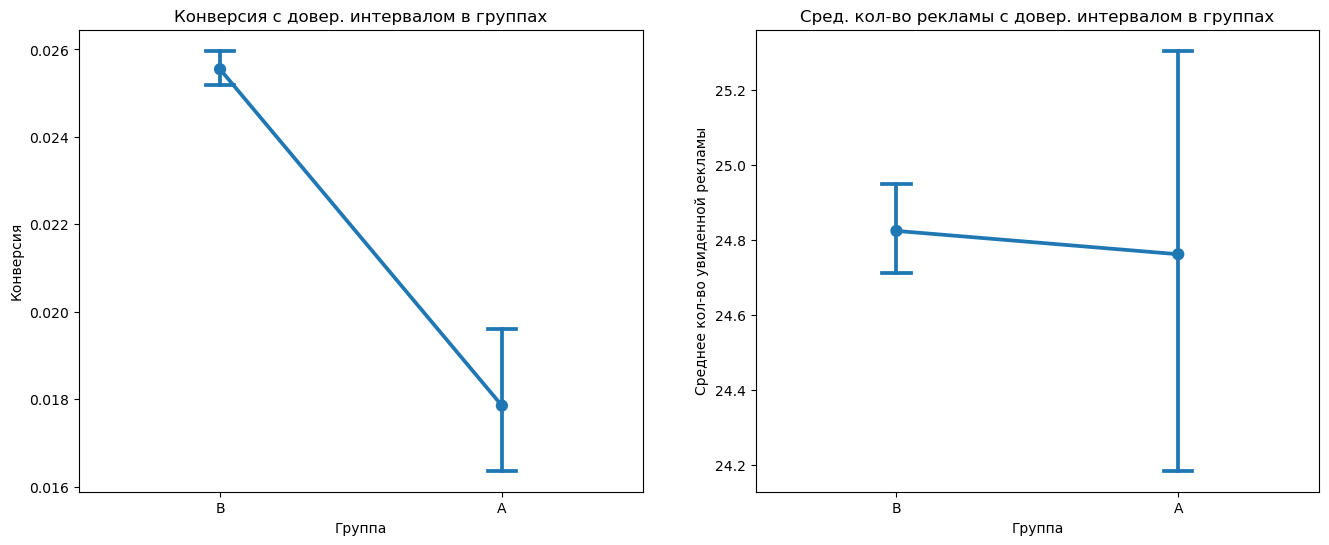

In [39]:
# Для демонстрации распределений двух метрик в обеих группах с отображением доверительных интервалов используем pointplot
# (точечный график). На первом - конверсии (в д.ед.) для обеих групп, на втором - среднее кол-во рекламы, увиденное 
# пользователями, для обеих групп.

# Cоздаём два графика размером 12x4
fig = plt.figure(figsize=(16, 6))

# Первый график с конверсиями и доверительными интервалами для групп
plt.subplot(121)
sns.pointplot(data=ab_data, x='test group', y='converted', capsize=.1)
plt.title("Конверсия с довер. интервалом в группах")
plt.xlabel("Группа")
plt.ylabel("Конверсия")

# Второй график со средними кол-вами увиденной рекламы и доверительными интервалами для групп
plt.subplot(122)
sns.pointplot(data=ab_data, x='test group', y='total ads', capsize=.1)
plt.title("Сред. кол-во рекламы с довер. интервалом в группах")
plt.xlabel("Группа")
plt.ylabel("Среднее кол-во увиденной рекламы")

plt.show()

**Конверсии**: Доверительные интервалы для конверсий в обеих группах не перекрываются, что указывает на статистически значимую разницу в конверсиях между группами. Конверсия в группе B (ad) выше, чем в группе A (psa), и этот результат является статистически надежным.

**Разница конверсий**: Доверительный интервал для разницы конверсий также подтверждает, что разница между группами статистически значима и положительна, что означает эффективность рекламы по метрике конверсии в группе B (ad).  

**Среднее количество увиденной рекламы**: Наблюдаем перекрытие между доверительными интервалами обеих групп. Это перекрытие указывает на то, что средние значения количества увиденной рекламы могут быть схожими в обеих группах, хотя среднее в группе B (ad) немного выше. Это подтверждает предыдущий вывод о том, что разница в среднем количестве увиденной рекламы между группами, хотя статистически значима, скорее всего практически не значима. Также стоит отметить, что более узкий доверительный интервал для группы B (ad) указывает на более высокую точность оценки среднего в этой группе по сравнению с группой A (psa).  
 
Отсюда, разница в конверсии между группами A и B скорее всего связана не с количеством рекламы, а с её качеством. Возможно,  важно фокусироваться на качестве и содержании рекламы для достижения лучших результатов.  

Основываясь на приведенном анализе, реклама была успешной, следует продолжать инвестировать в рекламу, аналогичную той, что была представлена в группе B (ad), поскольку наблюдалась лучшая эффективность в плане конверсии.